This notebook uses compiled version of the computeVPB function. To compile it run the command

    python setup.py build_ext --inplace

from the `python/` directory

See https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html for some basic tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ripser
import persim


In [2]:
import TDAvec
from TDAvec import pmin, pmax, DiagToPD, \
    computeVPB, computePL, computePS, computeNL, computeVAB, computeECC, computePES

In [3]:
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
D = ripser.ripser(X, thresh=2)["dgms"]
D[0][-1, 1] = 2


## computeVPB

In [4]:
PD = DiagToPD(D)
ySeqH0 = np.quantile(PD[0][1], np.arange(0, 1.1, 0.2))
xSeqH1 = np.quantile(PD[1][0], np.arange(0, 1.1, 0.2))
ySeqH1 = np.quantile(PD[1][1], np.arange(0, 1.1, 0.2))

vpb0 = computeVPB(PD, homDim=0, xSeq=[], ySeq=ySeqH0)
print(np.allclose(
    vpb0, 
    np.loadtxt("../R/vpb_0.csv", skiprows=1)
    ))
vpb1 = computeVPB(PD, homDim = 1, xSeq=xSeqH1, ySeq=ySeqH1)
vpb1 = np.transpose(vpb1).reshape( (25,))
print(np.allclose(
    vpb1, 
    np.loadtxt("../R/vpb_1.csv", skiprows=1)
    , atol=1e-7))


True
True


## computePI

In [5]:
from scipy.stats import norm
def pnorm(x, mean, sd):
    return norm.cdf(x, mean, sd)

def outer(x, y):
    return np.array([x_*y_ for y_ in y for x_ in x])
outer([1,2,3], [4,5])

array([ 4,  8, 12,  5, 10, 15])

In [6]:
def PSurfaceH0(point, y_lower, y_upper, sigma, maxP):
    y = point[1]
    out2 = pnorm(y_upper, y, sigma) - pnorm(y_lower, y, sigma)
    wgt = y/maxP if y<maxP else 1
    return wgt*out2
def PSurfaceHk(point, y_lower, y_upper, x_lower, x_upper, sigma, maxP):
    x, y = point[0], point[1]
    out1 = pnorm(x_upper,x,sigma) - pnorm(x_lower,x,sigma)
    out2 = pnorm(y_upper,y,sigma) - pnorm(y_lower,y,sigma)
    wgt = y/maxP if y<maxP else 1
    return wgt*outer(out1, out2)

In [7]:
def computePI(PD, homDim, xSeq, ySeq, sigma):
    D_ = np.transpose(PD[homDim])
    n_rows = D_.shape[0]

    resB = len(xSeq) - 1
    resP = len(ySeq)-1
    minP, maxP = ySeq[0], ySeq[-1]
    dy = (maxP-minP)/resP
    y_lower = np.arange(minP, maxP, dy)
    y_upper = y_lower + dy

    nSize = resP if homDim == 0 else resP*resB
    Psurf_mat = np.zeros( (nSize, n_rows))
    if homDim==0:
        for i in range(n_rows):
            Psurf_mat[:, i] = PSurfaceH0(D_[i, :], y_lower, y_upper, sigma, maxP)
    else:
        minB, maxB = xSeq[0], xSeq[-1]
        dx = (maxB-minB)/resB
        x_lower = np.arange(minB, maxB, dx)
        x_upper = x_lower + dx
        for i in range(n_rows):
            Psurf_mat[:, i] = PSurfaceHk(D_[i, :], y_lower, y_upper, x_lower, x_upper, sigma, maxP)
    out = np.sum(Psurf_mat, axis = 1)
    return out


In [12]:
resB, resP = 5, 5
#
minPH0, maxPH0 = np.min(PD[0][1,:]), np.max(PD[0][1,:])
ySeqH0 = np.linspace(minPH0, maxPH0, resP+1)
xSeqH0 = np.zeros( resB+1)

minBH1, maxBH1 = np.min(PD[1][0,:]), np.max(PD[1][0,:])
xSeqH1 = np.linspace(minBH1, maxBH1, resB+1)
minPH1, maxPH1 = np.min(PD[1][1,:]), np.max(PD[1][1,:])
ySeqH1 = np.linspace(minPH1, maxPH1, resP+1)

sigma = 0.5*(maxPH0-minPH0)/resP
pi0 = computePI(PD, homDim = 0, xSeq = xSeqH0, ySeq = ySeqH0, sigma = sigma)
pi0_R = np.loadtxt("../R/pi_0.csv", skiprows=1)
print(0, np.allclose(pi0, pi0_R))

sigma = 0.5*(maxPH1-minPH1)/resP
pi1 = computePI(PD, homDim = 1, xSeq = xSeqH1, ySeq = ySeqH1, sigma = sigma)
pi1_R = np.loadtxt("../R/pi_1.csv", skiprows=1)
print(1, np.allclose(pi1, pi1_R))


0 True
1 True


In [ ]:
PD[1]

array([[0.44604498, 0.40888548],
       [0.01355717, 0.86032665]])

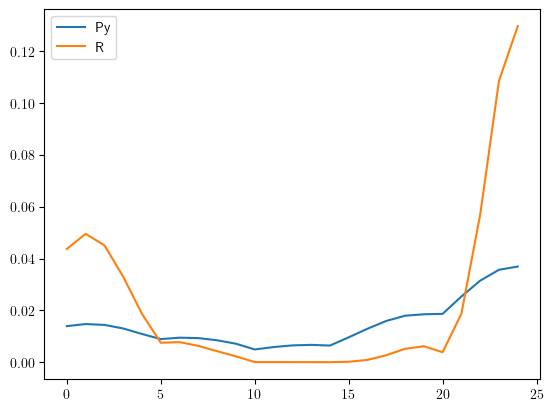

In [ ]:
pi1_R = np.loadtxt("../R/pi_1.csv", skiprows=1)
plt.plot(pi1, label = "Py")
plt.plot(pi1_R, label = "R")
plt.legend()

In [ ]:

homDim = 0
ySeq = ySeqH0
D_ = np.transpose(PD[0])
n_rows = D_.shape[0]

resP = len(ySeq)-1
minP = ySeq[0]
maxP = ySeq[-1]
dy = (maxP-minP)/resP
y_lower = np.arange(minP, maxP, dy)
y_upper = y_lower + dy

nSize = resP if homDim == 0 else resP*resB
Psurf_mat = np.zeros( (nSize, n_rows))
for i in range(n_rows):
    Psurf_mat[:, i] = PSurfaceH0(D_[i, :], y_lower, y_upper, sigma, maxP)
out = np.sum(Psurf_mat, axis = 1)
np.allclose(out, np.loadtxt("../R/pi_0.csv", skiprows=1))


## Others

In [ ]:
scaleSeq = np.linspace(0, 2, 11)
# universal function for comparison
def compareResults(func, R_prefix, maxDim = 1, D=D, scaleSeq = scaleSeq, atol = 1e-7):
    print(f"Comparing compute{R_prefix.upper()}:")
    # for each of the dims
    for d in range(maxDim+1):
        # calc python result
        pyth = func(D, d, scaleSeq)
        # read R result
        R = np.loadtxt(f"../R/{R_prefix}_{d}.csv", skiprows=1)
        # report if they are equal
        print("\t dim=", d, ":", np.allclose(pyth, R, atol=atol))


In [ ]:
testDict = {"pl":computePL, "ps":computePS, "nl":computeNL, "vab":computeVAB, "ecc":computeECC, "pes": computePES}
for p in testDict.keys():
    compareResults(testDict[p], p)

Comparing computePL:
	 dim= 0 : True
	 dim= 1 : True
Comparing computePS:
	 dim= 0 : True
	 dim= 1 : True
Comparing computeNL:
	 dim= 0 : True
	 dim= 1 : True
Comparing computeVAB:
	 dim= 0 : True
	 dim= 1 : True
Comparing computeECC:
	 dim= 0 : True
	 dim= 1 : True
Comparing computePES:
	 dim= 0 : True
	 dim= 1 : True
